In [5]:
# Importing our required libraries
import os
import pandas as pd
from lxml import etree
from bs4 import BeautifulSoup
import random
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from nltk.tokenize import word_tokenize
import nltk
import spacy
import re

# scikit-learn library will generate our document-term matrix
import sklearn
from sklearn.feature_extraction.text import CountVectorizer

# topic modelling
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer

import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import gensim


# Plotting tools
import pyLDAvis
import pyLDAvis.gensim
from pprint import pprint

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

import random
random.seed(929)

## Extract information from xml
The dataset contains all the Wall Street Journal articles from 2019 to 2020, and are in the form of xmls.

In [113]:
## Direction of files
dataset_directory = '../data/data_wsj/'
input_files = os.listdir(dataset_directory)


In [114]:
# We define a function to get the text content that we need from the XML articles available in our dataset
def getxmlcontent(root):
    if root.find('.//HiddenText') is not None:
        return(root.find('.//HiddenText').text)
    
    elif root.find('.//Text') is not None:
        return(root.find('.//Text').text)
    
    else:
        return None

In [115]:
# empty list to store the information extracted
file_name =[]
company_list = []
topic_list = []
geographic = []
content = []
date_list = []
title_list = []
person_list = []
subject_list = []


# Parse files and add data to lists
for file in input_files:
    tree = etree.parse(dataset_directory + file)
    root = tree.getroot()
    
    if getxmlcontent(root) is not None:
        soup = BeautifulSoup(getxmlcontent(root))
        text = soup.get_text()
    else:
        text = 'Error in processing document'
        
    date = root.find('.//NumericDate').text # date
    
    # entity-related
    topic = list(name.text for name in root.findall('.//GenSubjValue')) # topic, keywords
    location = list(name.text for name in root.findall('.//Geographic')) # location related
    company = list(name.text for name in root.findall('.//CompanyName')) # company related
    person = list(name.text for name in root.findall('.//Personal')) # person related
    
    
    title = root.find('.//Title').text #title
    
    # append the list accordingly
    file_name.append(file)
    company_list.append(company)
    topic_list.append(topic)
    geographic.append(location)
    content.append(text)
    date_list.append(date)
    title_list.append(title)
    person_list.append(person)

    
    

In [116]:
# store the information in the dataframe
df = pd.DataFrame({'Article ID': file_name,'Title': title_list, 'Text':content, 'Date': date_list, 'Company':company_list,
                  'Topics':topic_list, 'Location':geographic, 'Person':person_list})
display(df.head())

,Article ID,Title,Text,Date,Company,Topics,Location,Person
0,2424324530.xml,Rate for 30-Year Mortgage Falls to Lowest on R...,"\nIn a year of financial firsts, this one stan...",2020-07-17,"[Fannie Mae, Freddie Mac, Fannie Mae, Freddie ...","[Purchasing, Home loans, Real estate sales, Pa...",[],[]
1,2249646792.xml,New Jersey Averts Government Shutdown --- Gov....,\nNew Jersey Gov. Phil Murphy signed a $38.7 b...,2019-07-01,"[Senate, NJ Transit]","[Governors, Legislatures, Tax rates, Governmen...",[New Jersey],"[Bramnick, Jon]"
2,2325697446.xml,Trump's Impeachment Rebuke Bookended by Policy...,\nWASHINGTON -- Even for a presidency defined ...,2019-12-14,"[Brookings Institution, Congress, Islamic Stat...","[Investigations, Presidents, Impeachment, Cand...","[Mexico, Russia, United States--US, Canada, Wa...","[Trump, Donald J, Parscale, Brad, Pelosi, Nanc..."
3,2218797313.xml,Washington's Biggest Lobbyist Gets Shut Out --...,"\nA month before his inauguration, and shortly...",2019-05-03,"[Republican Party, US Chamber of Commerce]","[Nominations, Health care policy, Political ca...",[United States--US],"[Trump, Donald J, Coats, Dan]"
4,2352540052.xml,Dollar's Surge Is Hurdle for Shares,\nInvestors worried about the impact of the co...,2020-02-10,"[PepsiCo Inc, Columbia Threadneedle Investment...","[Coronaviruses, Global economy, Interest rates...","[United Kingdom--UK, New York, United States--...","[Trump, Donald J]"


In [6]:
# save the file to csv
df.to_csv('..//data/wsj.csv', index = False)

In [41]:
# import the csv file
wsj = pd.read_csv('..//data/wsj.csv')
display(wsj.head())

,Article ID,Title,Text,Date,Company,Topics,Location,Person
0,2424324530.xml,Rate for 30-Year Mortgage Falls to Lowest on R...,"\nIn a year of financial firsts, this one stan...",2020-07-17,"['Fannie Mae', 'Freddie Mac', 'Fannie Mae', 'F...","['Purchasing', 'Home loans', 'Real estate sale...",[],[]
1,2249646792.xml,New Jersey Averts Government Shutdown --- Gov....,\nNew Jersey Gov. Phil Murphy signed a $38.7 b...,2019-07-01,"['Senate', 'NJ Transit']","['Governors', 'Legislatures', 'Tax rates', 'Go...",['New Jersey'],"['Bramnick, Jon']"
2,2325697446.xml,Trump's Impeachment Rebuke Bookended by Policy...,\nWASHINGTON -- Even for a presidency defined ...,2019-12-14,"['Brookings Institution', 'Congress', 'Islamic...","['Investigations', 'Presidents', 'Impeachment'...","['Mexico', 'Russia', 'United States--US', 'Can...","['Trump, Donald J', 'Parscale, Brad', 'Pelosi,..."
3,2218797313.xml,Washington's Biggest Lobbyist Gets Shut Out --...,"\nA month before his inauguration, and shortly...",2019-05-03,"['Republican Party', 'US Chamber of Commerce']","['Nominations', 'Health care policy', 'Politic...",['United States--US'],"['Trump, Donald J', 'Coats, Dan']"
4,2352540052.xml,Dollar's Surge Is Hurdle for Shares,\nInvestors worried about the impact of the co...,2020-02-10,"['PepsiCo Inc', 'Columbia Threadneedle Investm...","['Coronaviruses', 'Global economy', 'Interest ...","['United Kingdom--UK', 'New York', 'United Sta...","['Trump, Donald J']"


## Topic Modelling with Gensim 
Reference:
1. https://towardsdatascience.com/topic-modelling-in-python-with-nltk-and-gensim-4ef03213cd21
2. https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

In [42]:
sp = spacy.load('en_core_web_sm')
all_stopwords = sp.Defaults.stop_words # list of stop words

# find the meanings of words, synonyms, antonyms, and more
def get_lemma(word):
    lemma = wn.morphy(word)
    if lemma is None:
        return word
    else:
        return lemma

# get the root word
def get_lemma2(word):
    return WordNetLemmatizer().lemmatize(word)

# define the function to clean the test -remove stop words, punctuation
def clean_text(text):
    s = re.sub(r'[^\w\s]','', text) #remove punctuation
    word = s.split() # convert the text to a list of words
    word = [x.lower() for x in word] # convert to lower case
    word = [wo for wo in word if not wo in all_stopwords] # remove stop words
    return word


# prepare the text for topic modelling
def prepare_text_for_lda(text):
    tokens = clean_text(text)
    tokens = [token for token in tokens if token not in all_stopwords]
    tokens = [token for token in tokens if len(token) > 4]
    tokens = [get_lemma(token) for token in tokens]
    return tokens


In [43]:
data1 = wsj.Text.values.tolist() # convert the text to list
data = [prepare_text_for_lda(text) for text in data1] # clean the text

In [44]:
# Create Dictionary
id2word = corpora.Dictionary(data)

# Create Corpus
texts = data

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [50]:
# define the function to find the optimal number of topics
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [51]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data, start=2, limit=40, step=6)

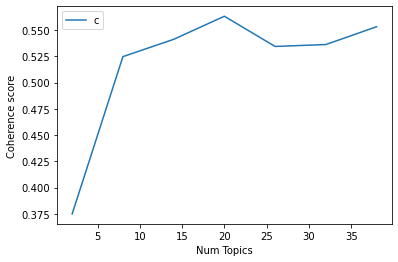

In [52]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [53]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))


Num Topics = 2  has Coherence Value of 0.375
Num Topics = 8  has Coherence Value of 0.5247
Num Topics = 14  has Coherence Value of 0.5412
Num Topics = 20  has Coherence Value of 0.5632
Num Topics = 26  has Coherence Value of 0.5344
Num Topics = 32  has Coherence Value of 0.5362
Num Topics = 38  has Coherence Value of 0.5532


In [54]:
# Select the optimal model and print the topics
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.020*"company" + 0.018*"market" + 0.016*"investor" + 0.014*"price" + '
  '0.012*"billion" + 0.012*"share" + 0.008*"investment" + 0.008*"stock" + '
  '0.007*"analyst" + 0.006*"stocks"'),
 (1,
  '0.009*"farmer" + 0.007*"water" + 0.007*"plant" + 0.006*"world" + '
  '0.005*"years" + 0.005*"japan" + 0.005*"produce" + 0.004*"brazil" + '
  '0.004*"space" + 0.004*"credit"'),
 (2,
  '0.027*"store" + 0.022*"sales" + 0.015*"restaurant" + 0.013*"retailer" + '
  '0.013*"amazon" + 0.011*"brand" + 0.010*"product" + 0.009*"customer" + '
  '0.009*"online" + 0.008*"delivery"'),
 (3,
  '0.015*"police" + 0.008*"charge" + 0.007*"company" + 0.007*"officer" + '
  '0.007*"people" + 0.007*"department" + 0.006*"court" + 0.006*"investigation" '
  '+ 0.006*"facebook" + 0.006*"accord"'),
 (4,
  '0.010*"apple" + 0.010*"child" + 0.009*"people" + 0.006*"company" + '
  '0.005*"phone" + 0.005*"parent" + 0.005*"technology" + 0.005*"family" + '
  '0.004*"product" + 0.004*"call"'),
 (5,
  '0.008*"people" + 0.006*

In [57]:
def format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data1)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,14.0,0.6253,"economy, banks, market, rates, economic, inves...","\nIn a year of financial firsts, this one stan..."
1,1,10.0,0.8559,"state, county, city, california, mayor, offici...",\nNew Jersey Gov. Phil Murphy signed a $38.7 b...
2,2,11.0,0.8427,"trump, president, house, republican, democrat,...",\nWASHINGTON -- Even for a presidency defined ...
3,3,11.0,0.4268,"trump, president, house, republican, democrat,...","\nA month before his inauguration, and shortly..."
4,4,0.0,0.4884,"company, market, investor, price, billion, sha...",\nInvestors worried about the impact of the co...
5,5,0.0,0.4681,"company, market, investor, price, billion, sha...",\nClayton Dubilier & Rice could collect about ...
6,6,0.0,0.4948,"company, market, investor, price, billion, sha...",\nThe S&P 500 and Nasdaq Composite notched rec...
7,7,4.0,0.5806,"apple, child, people, company, phone, parent, ...",\nIs a full face of makeup too much on a video...
8,8,18.0,0.3145,"official, military, force, saudi, attack, stat...",\nLess than a week after a withering attack on...
9,9,17.0,0.6655,"coronavirus, virus, case, people, pandemic, st...",\nTOKYO -- Japan introduced some of the strict...


In [58]:
sent_topics_sorteddf = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf = pd.concat([sent_topics_sorteddf, grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], axis=0)

# Reset Index    
sent_topics_sorteddf.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.9978,"company, market, investor, price, billion, sha...",\nInvestors are trading stock options and chas...
1,1.0,0.9703,"farmer, water, plant, world, years, japan, pro...",\n[Provided by Serhiy and Peter Grabarchuk (gr...
2,2.0,0.9604,"store, sales, restaurant, retailer, amazon, br...",\n[Satisfying and Seasonal Food in About 30 Mi...
3,3.0,0.9923,"police, charge, company, officer, people, depa...",\nMANHATTAN\nPolice Loudspeaker\nIncident Spar...
4,4.0,0.9530,"apple, child, people, company, phone, parent, ...","\nAs the new coronavirus spreads, more compani..."
5,5.0,0.9333,"people, woman, movie, years, black, disney, wo...",\n\n ...
6,6.0,0.9967,"company, airline, maker, boeing, executive, ve...",\nBoeing Co. hopes to deliver 737 MAX aircraft...
7,7.0,0.9958,"company, million, billion, business, executive...",\nUnivision Communications Inc. agreed to sell...
8,8.0,0.9960,"china, chinese, trade, trump, beijing, governm...",\nWASHINGTON -- President Trump praised Mexico...
9,9.0,0.9957,"patient, vaccine, health, study, doctor, medic...",\nA study of hospitalized patients with Covid-...


In [59]:
# save the topic_num, topic_perc to wsj dataframe
wsj['Topic_Num'] = df_dominant_topic['Dominant_Topic']
wsj['Topic_Perc_Contrib'] = df_dominant_topic['Topic_Perc_Contrib']
wsj['Keywords'] = df_dominant_topic['Keywords']
# wsj.head()